## Imports

In [2]:
import PIL.Image
from PIL.ImageColor import colormap
from sympy.codegen.rewriting import optimize
# Torch Imports
from torchvision.models import resnet
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, RandomSampler
from torch import nn
from torch.optim import Adam

import torch

# Dataset Related
import kagglehub

# Plots and numpy
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
np.random.seed(42)

import os
import time


#Utils
from utils.plot import  plot_classes, plot_random_six_images, plot_loss, plot_time

# Dataset
In this repo I will use *Stanford Dogs Dataset* from kaggle
https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset

Originally from http://vision.stanford.edu/aditya86/ImageNetDogs/


## Getting Data

In [3]:
# Download latest version
DATA_PATH = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")
IMG_PATH = os.path.join(DATA_PATH, "images", "Images")
ANNOTATION_PATH = os.path.join(DATA_PATH, "annotations", "Annotations")

print("Path to dataset files:", DATA_PATH)

Path to dataset files: /home/franio/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2


In [4]:
dataset = datasets.ImageFolder(root=IMG_PATH)

## Transforms

Normalization is done with standard image net $\mu$ and $\sigma$

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


train_transform = transforms.Compose([transforms.Resize((224,224)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)])

test_transform = transforms.Compose([transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)])

val_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

## Train, Val and Test Split
I will use 0.7/0.2/0.1 split
%TODO: I assume that 10k images in total is enough for fine tuning. I will reconsider this value after testing a model. -> with torch split random

In [6]:
N = len(dataset)

train_size = int(np.ceil(0.7*N))
val_size = int(np.ceil(0.2*N))
test_size = int(N - train_size - val_size)


training_set, testing_set, validation_set = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

training_set.dataset.transform = train_transform
validation_set.dataset.transform = val_transform
testing_set.dataset.transform = test_transform

print(f'Training set size:\t\t{len(training_set)}\n'
      f'Testing set size:\t\t{len(testing_set)}\n'
      f'Validation set size:\t{len(validation_set)}\n')

Training set size:		14406
Testing set size:		2058
Validation set size:	4116



## Data vizualzation

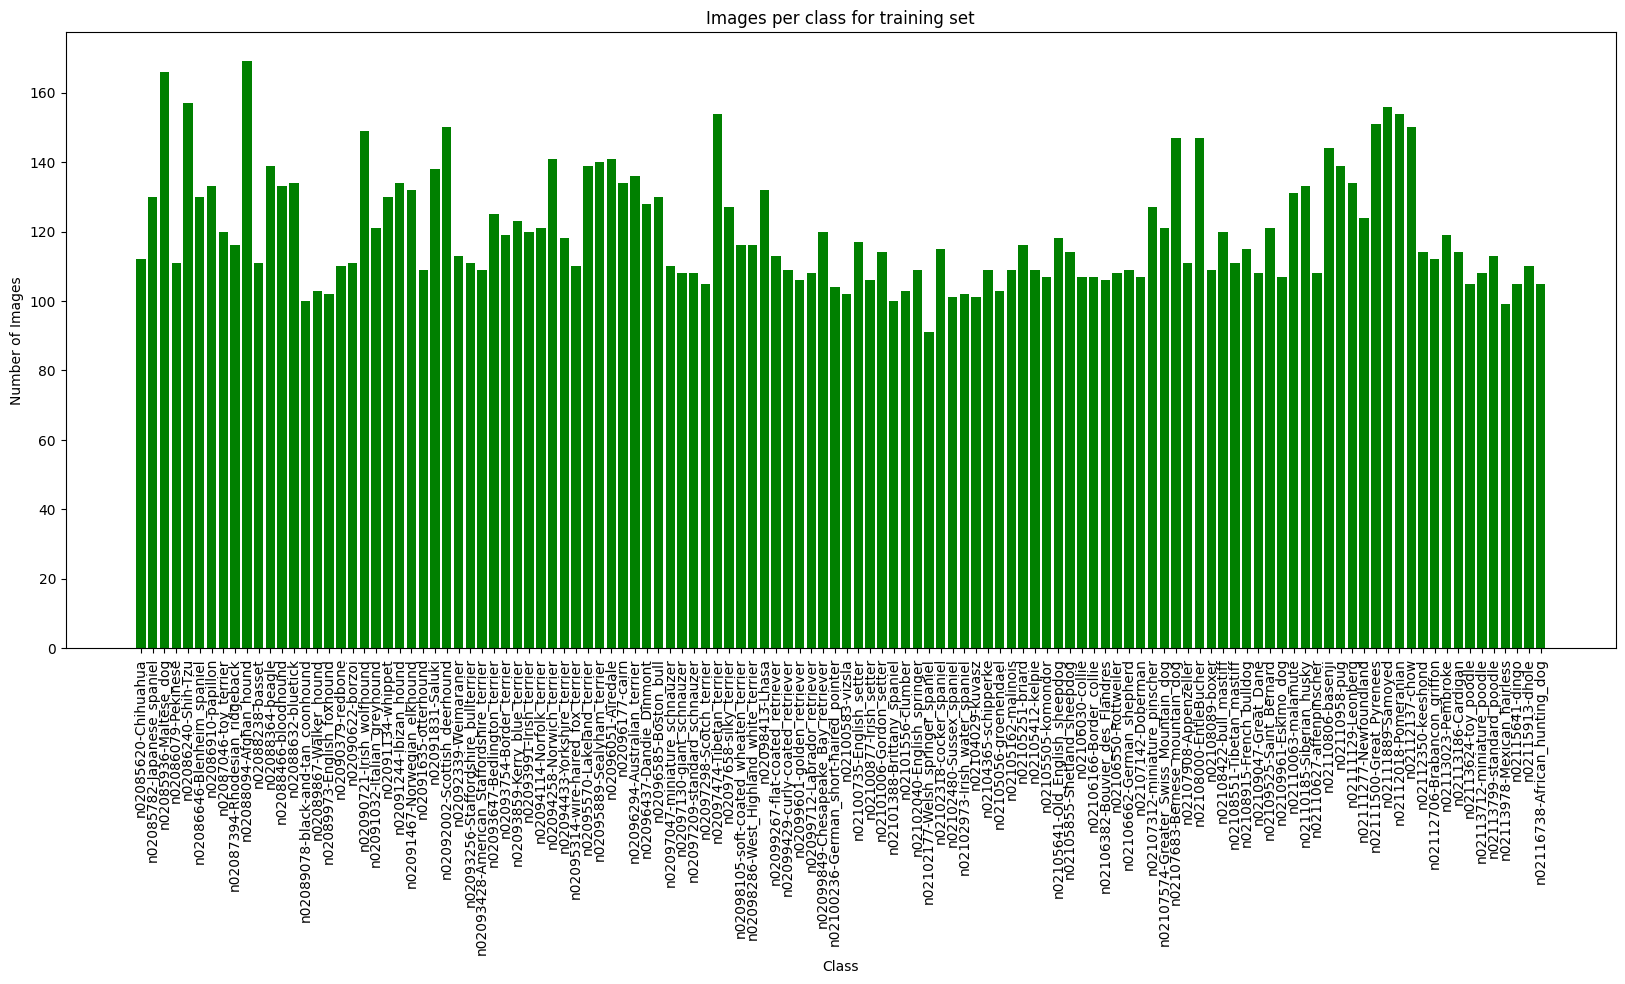

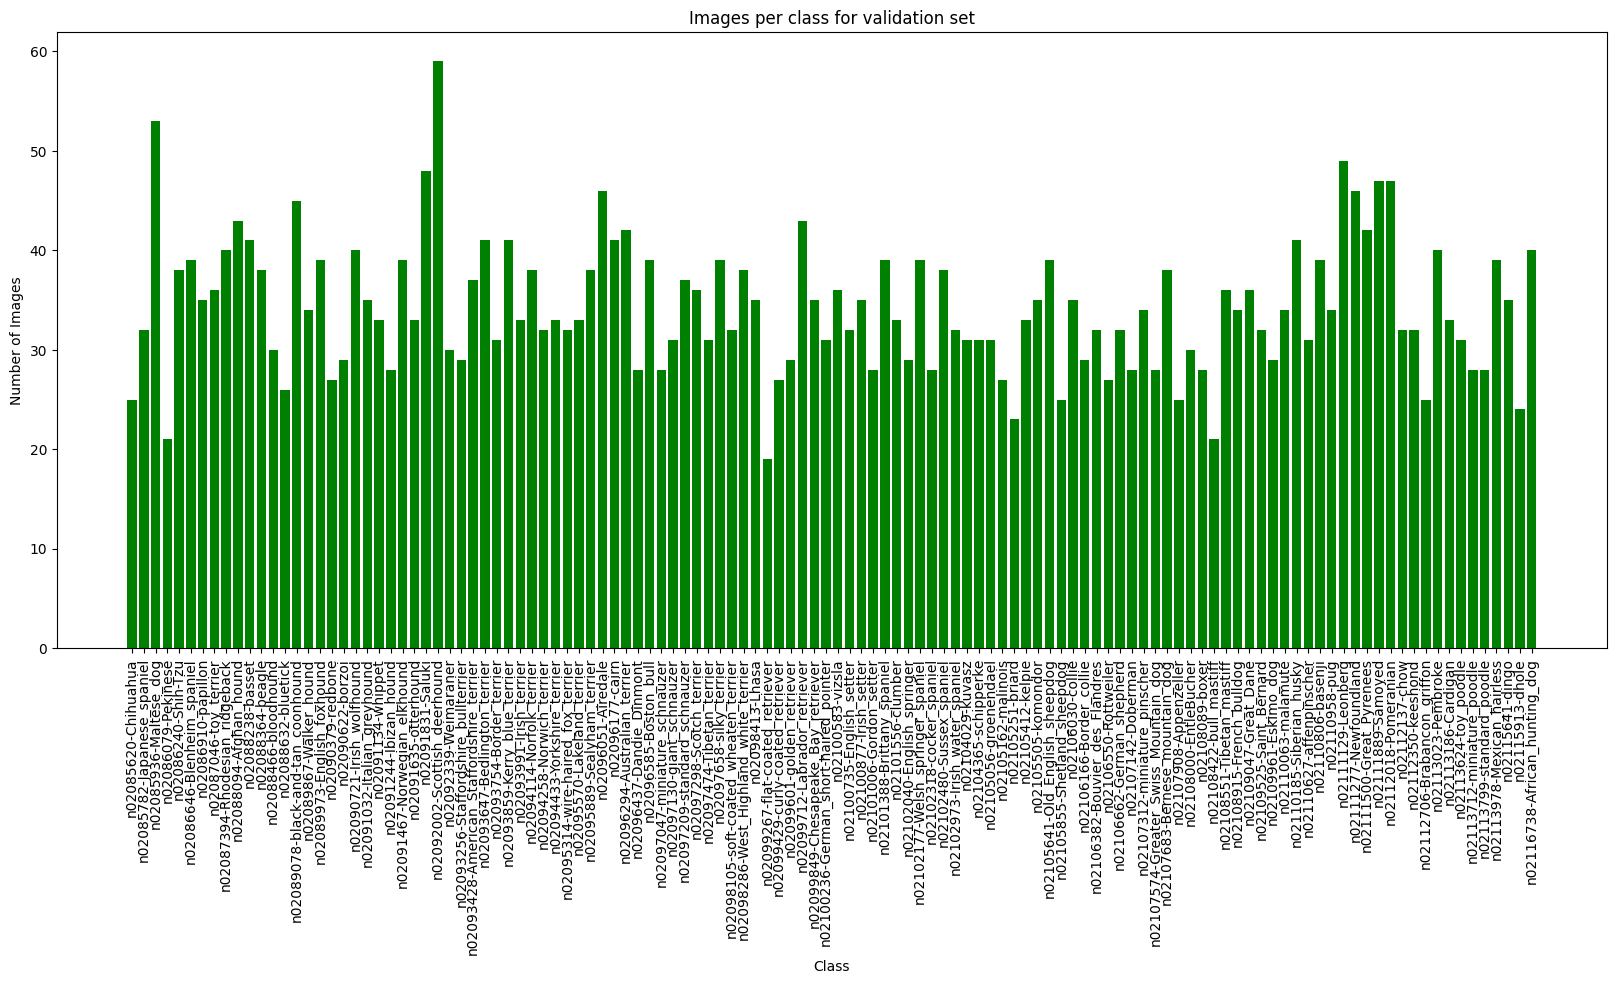

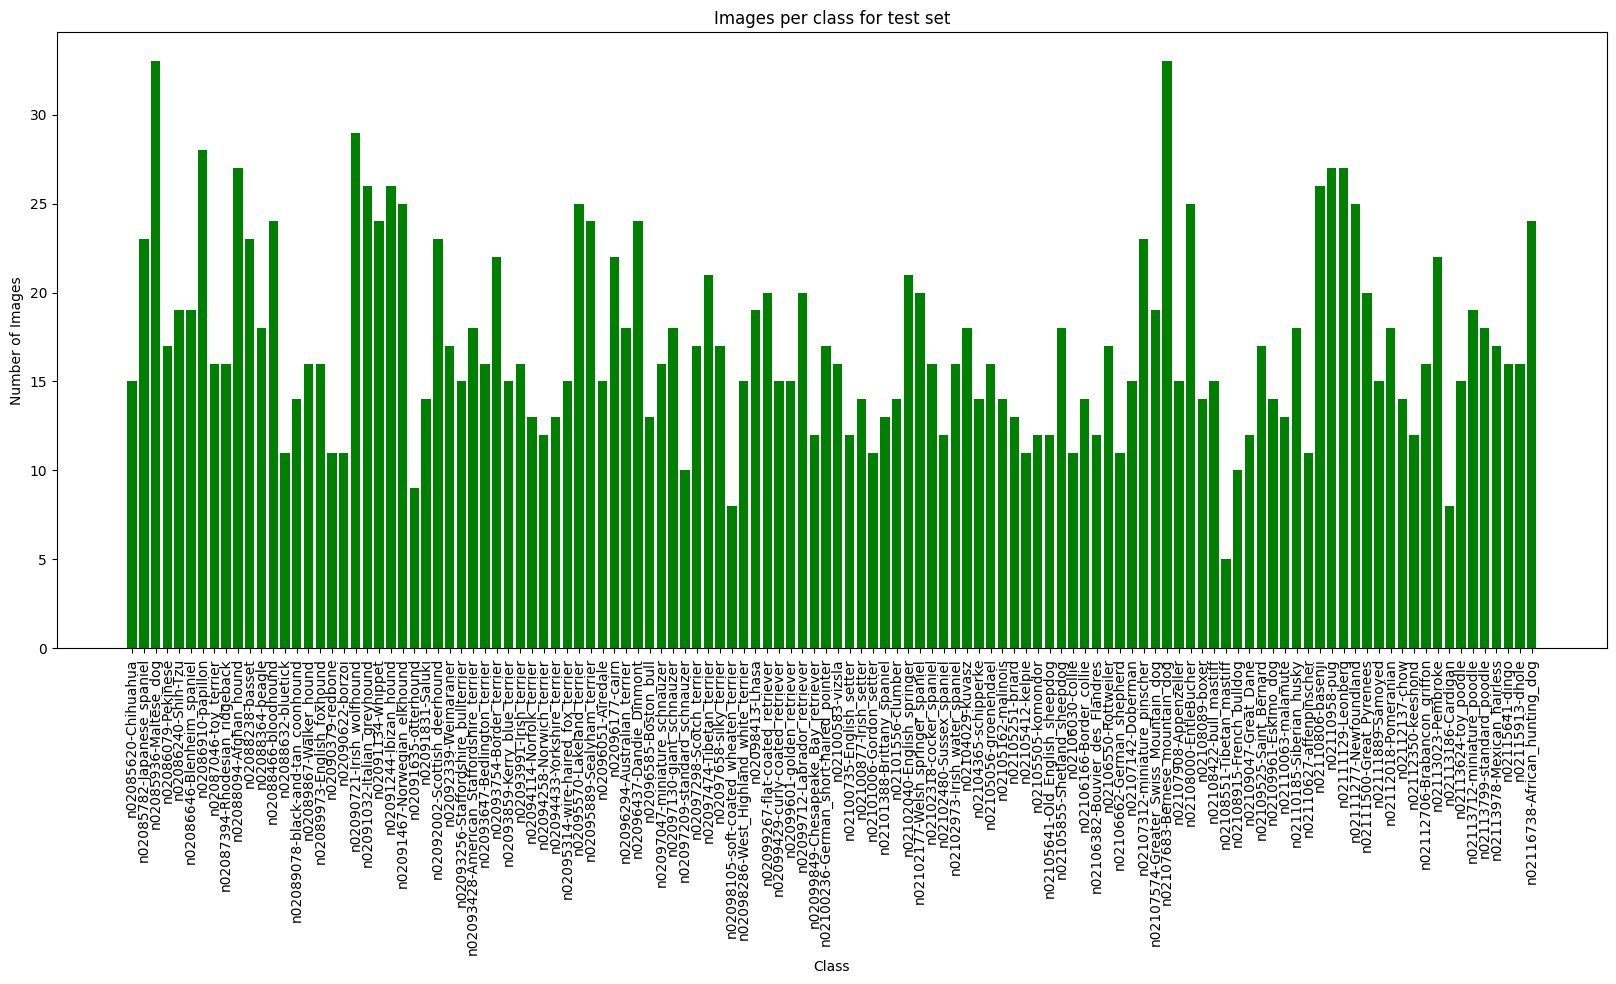

In [10]:
plot_classes(training_set, dataset.classes, set_name="training")
plot_classes(validation_set, dataset.classes, set_name="validation")
plot_classes(testing_set, dataset.classes, set_name="test")

## Image Vizualization

[16226  3388 20011  1427 19697  5883]


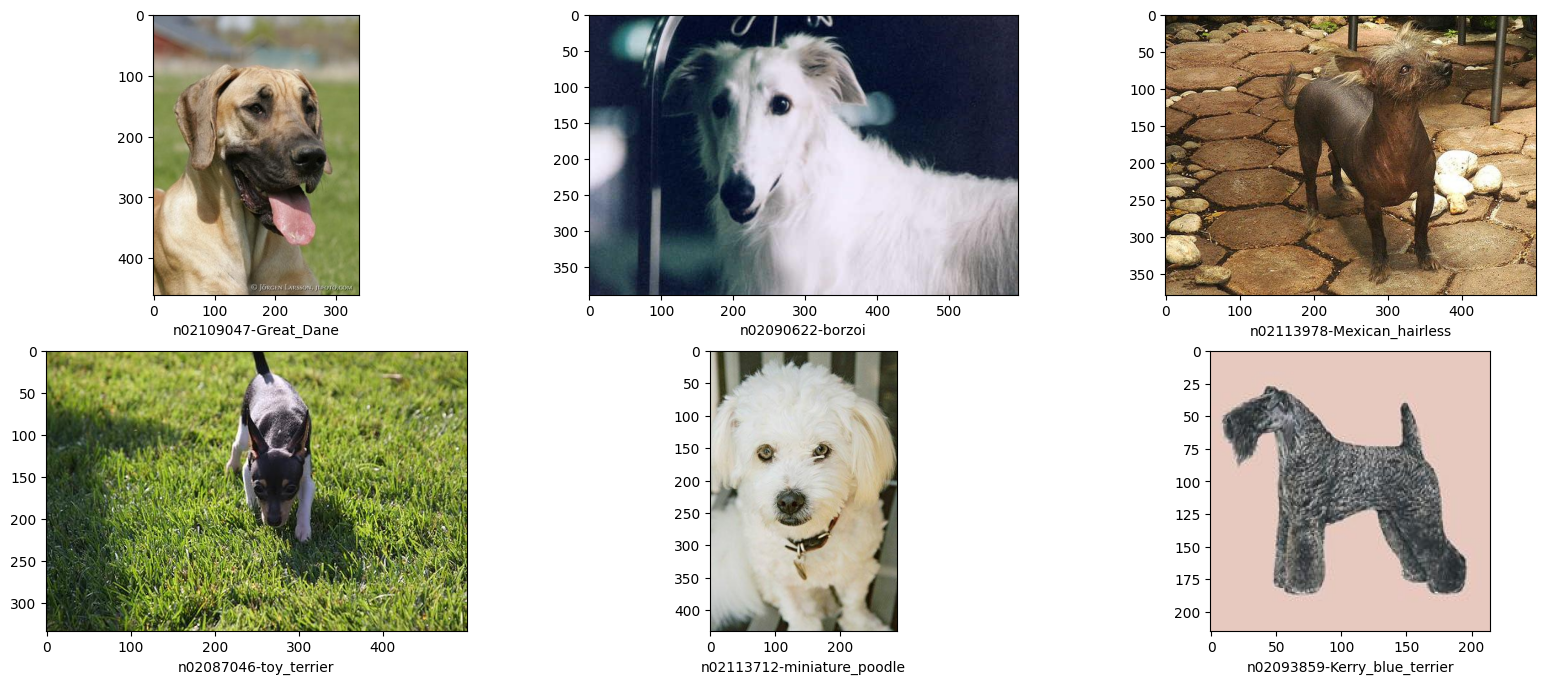

In [11]:
photos = datasets.ImageFolder(root=IMG_PATH)
plot_random_six_images(photos, photos.classes)

# DataLoaders

In [7]:
batch_size = 32


training_set_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_set_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)
testing_set_loader = DataLoader(testing_set, batch_size=batch_size, shuffle=False)

# Loading ResNet Modela

In [13]:
net_model = resnet.resnet18(weights=resnet.ResNet18_Weights.DEFAULT)
net_name = 'resnet18_Default' # To prevent saving not fine tuned model as fine tuned

net_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Model Vizualization

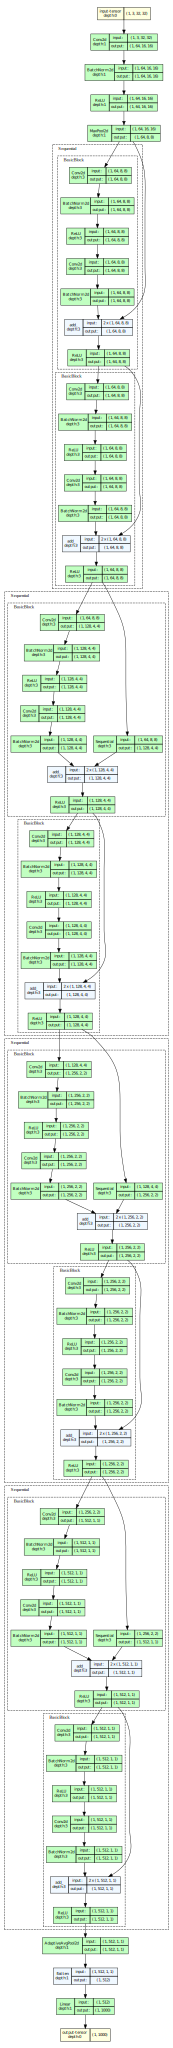

In [14]:
from torchview import draw_graph

model_graph = draw_graph(resnet.resnet18(), input_size=(1,3,32,32), expand_nested=True)
model_graph.visual_graph

### Unfreezing Layers

In [15]:
dropout_ratio = 0.9
unfrozen_layers = ['layer4', 'fc']

for name, child in net_model.named_children():
    if name in unfrozen_layers:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False

total_params = sum(param.numel() for param in net_model.parameters())
print(f'{total_params:,} total parameters')

total_trainable_params = sum(param.numel() for param in net_model.parameters() if param.requires_grad)
print(f'{total_trainable_params:,} training parameters')


conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen
11,689,512 total parameters
8,906,728 training parameters


# Model Training

## Training

In [18]:
MODEL_DIR = 'models'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())


lr = 3e-4
n_epochs = 25

criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adam(net_model.parameters(), lr=lr)

epochs = []
times = []
val_losses = []
train_losses = []


net_model.to(device)

for epoch in range(1, n_epochs+1):
    print(f'\n== Epoch {epoch} ==\n')
    epochs.append(epoch)

    val_loss = 0
    train_loss = 0

    start = time.time()

    net_model.train()
    for img, label in training_set_loader:
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = net_model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    stop = time.time()

    net_model.eval()
    for img,label in validation_set_loader:
        img = img.to(device)
        label = label.to(device)

        output = net_model(img)
        loss = criterion(output, label)
        val_loss += loss.item()

    times.append(stop - start)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if np.mod(epoch,5) == 0:
        net_name = f'resnet18_dogs_{epoch}_epochs'
        torch.save(net_model.state_dict(), os.path.join(MODEL_DIR, f"{net_name}.pth"))
        print('Model Saved')

    print(f"{train_loss=}\n{val_loss=}\ntime={stop-start}\n")

net_name = f'resnet18_dogs_{n_epochs}_epochs'
plot_time(times)
plot_loss(train_losses, val_losses)

NVIDIA GeForce GTX 1650 Ti

== Epoch 1 ==

train_loss=110.13457250595093
val_loss=187.37492555379868
time=60.399943590164185


== Epoch 2 ==

train_loss=63.130723813548684
val_loss=186.133314371109
time=59.592292070388794


== Epoch 3 ==

train_loss=37.37960257101804
val_loss=181.82097947597504
time=60.00415015220642


== Epoch 4 ==

train_loss=22.14977772720158
val_loss=204.87265503406525
time=61.42498588562012


== Epoch 5 ==

Model Saved
train_loss=33.759639486670494
val_loss=217.06974744796753
time=63.046278953552246


== Epoch 6 ==

train_loss=44.70576349552721
val_loss=203.53471273183823
time=61.231200218200684


== Epoch 7 ==



KeyboardInterrupt: 

In [20]:
print(net_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
MODEL_PATH = 'models'

os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(net_model.state_dict(), os.path.join(MODEL_PATH, f"{net_name}.pth"))

print(MODEL_PATH)

models


# Testing Model

In [8]:
from utils.metric_functions import test_model

NVIDIA GeForce GTX 1650 Ti
accuracy: 0.89067055393586


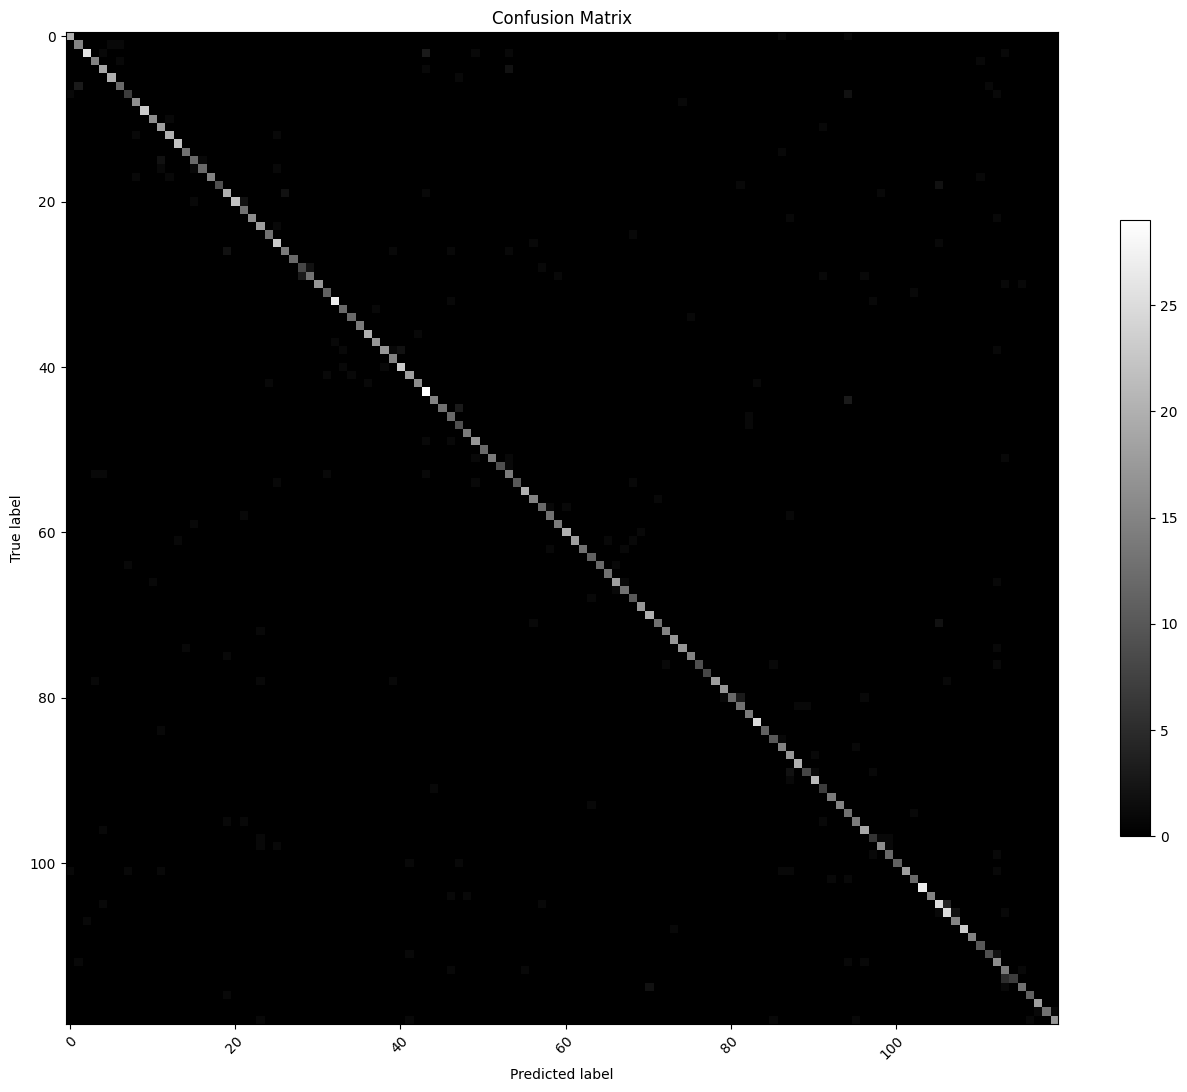

,precision,recall,f1-score,support
n02085620-Chihuahua,0.909091,0.909091,0.909091,22.000000
n02085782-Japanese_spaniel,0.789474,0.882353,0.833333,17.000000
n02085936-Maltese_dog,0.962963,0.787879,0.866667,33.000000
n02086079-Pekinese,0.882353,0.882353,0.882353,17.000000
n02086240-Shih-Tzu,0.826087,0.863636,0.844444,22.000000
...,...,...,...,...
n02115913-dhole,1.000000,0.866667,0.928571,15.000000
n02116738-African_hunting_dog,0.944444,0.772727,0.850000,22.000000
accuracy,0.890671,0.890671,0.890671,0.890671
macro avg,0.896376,0.888653,0.887808,2058.000000


In [9]:
MODEL_NAME = 'resnet18_dogs_5_epochs'

net_model = resnet.resnet18()
net_model.load_state_dict(torch.load(os.path.join('models', f"{MODEL_NAME}.pth"), weights_only=True))


test_model(MODEL_NAME, net_model, testing_set_loader, dataset.classes)